# Tutorial: Loading an USBMD data file
In this tutorial notebook we will show how to load an USBMD data file and how to access the data stored in it.

In [1]:
# Set the working directory to the root of the repository
# We do this by moving up until we find the file setup.cfg (which is in the
# root of the repository)
import os

while not os.path.exists('setup.cfg'):
    os.chdir('..')

In [2]:
# This cell is tagged with "parameters" so that it can be injected into the
# notebook when it is run by the unit test testing this notebook.
# The variable quick mode will then be set to True, allowing the notebook to
# run quickly for testing purposes.
# injected parameters
quick_mode = False

In [3]:
# imports
import warnings
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from usbmd.data_format.usbmd_data_format import load_usbmd_file
from usbmd.processing import log_compress, rf2iq
from usbmd.pytorch_ultrasound.layers.beamformers import get_beamformer
from usbmd.utils.config import load_config_from_yaml
from usbmd.utils.config_validation import check_config
from usbmd.utils.read_h5 import print_hdf5_attrs

## Viewing the file structure
The USBMD data format works with HDF5 files. We can open a USBMD data file using the `h5py` package and have a look at the contents using the print_hdf5_attrs function. You can see that every dataset element contains a corresponding description and unit.

We will demonstrate this by loading some example cardiac data from the NAS. We assume that the `Ultrasound-BMD` folder on the NAS is mapped to `Z:/` on your computer.

> *Tip:*
> You can also use the [HDFView](https://www.hdfgroup.org/downloads/hdfview/) tool to view the contents of the USBMD data file without having to run any code.

In [4]:
# Define path to the data file
data_path = r"Z:\Ultrasound-BMd\data\USBMD-example-data\planewave_l115v.hdf5"

# Uncomment to use the linescanning data instead
# data_path = r"Z:\Ultrasound-BMd\data\USBMD-example-data\linescanning_l115v.hdf5"

try:
    # Open the file and print the contents
    with h5py.File(data_path, 'r') as f:
        print_hdf5_attrs(f)


# If the file is not found, generate a dummy data file. This is mainly for
# running the notebook on the github server.
except FileNotFoundError:
    from usbmd.data_format.usbmd_data_format import generate_example_dataset
    data_path = r"generated_dummy_data.hdf5"
    generate_example_dataset(data_path, add_optional_fields=True)
    warnings.warn(f"Data file not found. Generated dummy data file.")

root/
    ├── description: Dataset of ultrasound data recorded with the Verasonics on 26-09-2023. The measurement data is stored under `data`. All parameters are stored under `scan.`
    ├── probe: verasonics_l11_5v
    ├── data/
    │   ├── beamformed_data/
    │   │   ├── /data/beamformed_data (shape=(6, 374, 128, 1))
    │   │   │   ├── description: The beamformed result from the Verasonics beamformer (ImgDataP) of shape (num_frames, n_rows, n_cols, n_slices). n_slices is used in 3D imaging.
    │   └── raw_data/
    │       ├── /data/raw_data (shape=(6, 7, 128, 2176, 1))
    │       │   ├── description: The raw_data of shape (n_frames, n_tx, n_el, n_ax, n_ch)
    │       │   ├── unit: unitless
    └── scan/
        ├── PRF/
        │   ├── /scan/PRF (shape=(1))
        │   │   ├── description: The pulse repetition frequency in Hz
        │   │   ├── unit: Hz
        ├── azimuth_angles/
        │   ├── /scan/azimuth_angles (shape=(7))
        │   │   ├── description: The azimuth ang

## Loading the file with the toolbox

In [5]:
# Load the data file and construct a probe and scan object
# We will only load the first two frames of the data file
selected_frames = [0, 1]
data, scan, probe = load_usbmd_file(data_path, frames=selected_frames)

# Print some info about the data
print('Data file loaded successfully')
print('The data tensor has shape: {}'.format(data.shape))
print('The dimensions of the data are (n_frames, n_transmits, n_elements, '
      'n_axial_samples, n_rf_iq_channels)')

# Reduce the beamforming grid in quick mode (during unit testing)
if quick_mode:
    scan.Nx = 32
    scan.Nz = 32

Data file loaded successfully
The data tensor has shape: (2, 7, 128, 2176, 1)
The dimensions of the data are (n_frames, n_transmits, n_elements, n_axial_samples, n_rf_iq_channels)


c:\Users\s154329\Projects\Ultrasound-BMd\usbmd\utils\pixelgrid.py:49: UserWarning: width/Nx = 0.0002977 < wvln/2 = 0.00010131578947368421. Consider increasing scan.Nx to 376 or more.
  warnings.warn(
c:\Users\s154329\Projects\Ultrasound-BMd\usbmd\utils\pixelgrid.py:54: UserWarning: depth/Nz = 0.0004189 < wvln/2 = 0.0001013. Consider increasing scan.Nz to 529 or more.
  warnings.warn(


## Beamforming the data
Now we would like to beamform the data to generate an image. For this we need to load a config file that contains the beamforming parameters. We can load a config using the `load_config_from_yaml` function. Once we have a config we create the beamformer using get_beamformer with the scan and probe class that we got from the data file.

In [6]:
# Load the config file
config_path = Path('configs', 'config_usbmd_rf.yaml')
config = load_config_from_yaml(config_path)

# Check the config file for errors
check_config(config)

# Create the beamformer
beamformer = get_beamformer(probe=probe, scan=scan, config=config)

In [7]:
# Swap the 3th and 4th axes
data = np.swapaxes(data, 3, 4)

# Transform the data to IQ data
iq_data = rf2iq(
    data,
    fs=scan.fs,
    fc=scan.fc,
    bandwidth=probe.bandwidth,
    separate_channels=False)

# Swap the 3th and 4th axes back
iq_data = np.swapaxes(iq_data, 3, 4)

# Turn the data into a torch tensor
iq_data = torch.from_numpy(iq_data)

# Beamform the data
beamformed_data = beamformer(iq_data)

# Convert the data to a numpy array and remove dummy dimensions
image = beamformed_data.numpy()[0, :, :, 0]

# Take the magnitude of the complex data (the envelope)
image = np.abs(image)

# Normalize the image and apply log compression
image = image/image.max()
image = log_compress(image)

## Plotting the result

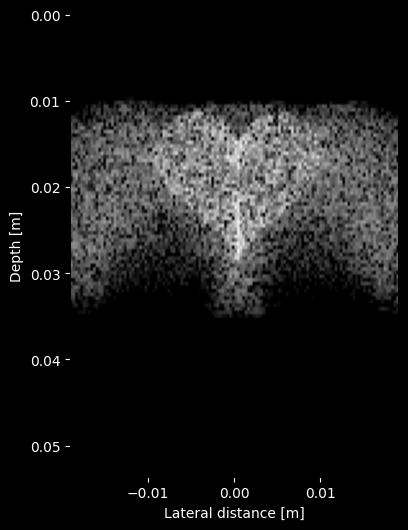

In [8]:
# Plot the image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image,
          cmap='gray',
          extent=[scan.xlims[0], scan.xlims[1], scan.zlims[1], scan.zlims[0]])

# Add labels
ax.set_xlabel('Lateral distance [m]')
ax.set_ylabel('Depth [m]')

# Turn the figure black
ax.set_facecolor((0, 0, 0))
fig.patch.set_facecolor((0, 0, 0))

# Turn the ticks white
ax.tick_params(axis='both', colors='white')

# Turn the labels white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

## Comparing to the image stored in the data file
Since this data file also already has processed image data inside we can plot this too and see if the result is the same.

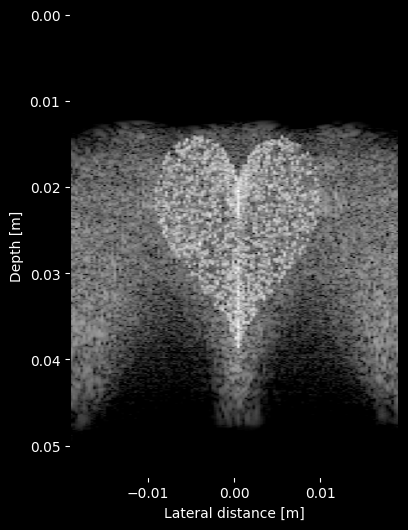

In [9]:
# Load the image data from the data file
try:
    image = load_usbmd_file(data_path, frames=selected_frames, data_type="beamformed_data")[0]
    image = image[0, :, :, 0]
    
# If the image data is missing, generate a dummy image
except KeyError:
    image = np.ones((128, 128))

# Apply log compression
image = log_compress(image/np.max(image))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image,
          cmap='gray',
          extent=[scan.xlims[0], scan.xlims[1], scan.zlims[1], scan.zlims[0]],
          vmin=-60)

# Add labels
ax.set_xlabel('Lateral distance [m]')
ax.set_ylabel('Depth [m]')

# Turn the figure black
ax.set_facecolor((0, 0, 0))
fig.patch.set_facecolor((0, 0, 0))

# Turn the ticks white
ax.tick_params(axis='both', colors='white')

# Turn the labels white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')